In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import yfinance as yf
from scipy.optimize import minimize

In [70]:
tickers = ["AAPL","MSFT","NVDA",
           "AMZN","GOOGL","META",
           "JPM","LULU","AMD",
           "ORCL","NFLX","DIS"]
start_date = "2010-01-01"
end_date = pd.Timestamp.today(tz="America/New_York").strftime("%Y-%m-%d")


In [71]:
def list_prices (tickers, start, end): 
    price = yf.download(tickers, start= start_date, end= end_date, auto_adjust=True, progress= False)

    if isinstance(price.columns,pd.MultiIndex):
        field = "Adj Close" if "Adj Close" in price.columns.get_level_values(0) else "Close"
        price = price[field].copy()
    price = price.sort_index()

    assert price.index.is_monotonic_increasing, "Index not increasing"

    price = price.dropna(how="all")
    miss_ratio = price.isna().mean()
    keep = miss_ratio[miss_ratio <= .10].index.tolist()
    price = price[keep]

    price = price.ffill()

    if price.isna().any().any():
        raise ValueError("Remaining NaNs after ffill-inspect data.")
    return price 


In [72]:
prices_output = list_prices(tickers, start_date, end_date)
prices_output.tail()

Ticker,AAPL,AMD,AMZN,DIS,GOOGL,JPM,LULU,MSFT,NFLX,NVDA,ORCL
Date,,,,,,,,,,,
2025-08-12,229.649994,174.949997,221.470001,113.720001,203.339996,292.850006,192.929993,529.239990,1225.280029,183.160004,253.860001
2025-08-13,233.330002,184.419998,224.559998,116.639999,201.960007,290.529999,200.490005,520.580017,1204.439941,181.589996,244.179993
2025-08-14,232.779999,180.949997,230.979996,116.309998,202.940002,294.160004,195.190002,522.479980,1230.560059,182.020004,244.960007
2025-08-15,231.589996,177.509995,231.029999,115.389999,203.899994,290.489990,198.460007,520.169983,1238.949951,180.449997,248.279999
2025-08-18,230.889999,176.139999,231.490005,116.550003,203.500000,291.529999,203.619995,517.099976,1245.089966,182.009995,249.070007


In [73]:
print("shape:",prices_output.shape)
print("tickers kept:",list(prices_output.columns))
print("any NaN left?", prices_output.isna().any().any())
print("data range:", prices_output.index.min(), "->", prices_output.index.max())

shape: (3930, 11)
tickers kept: ['AAPL', 'AMD', 'AMZN', 'DIS', 'GOOGL', 'JPM', 'LULU', 'MSFT', 'NFLX', 'NVDA', 'ORCL']
any NaN left? False
data range: 2010-01-04 00:00:00 -> 2025-08-18 00:00:00


In [74]:
returns_monthly = prices_output.resample("M").last().pct_change().dropna()

if returns_monthly.index[-1].to_period("M") == pd.Timestamp.today(tz="America/New_York").to_period("M"):
    returns_monthly = returns_monthly.iloc[:-1]

mu_returns_mean_ann = returns_monthly.mean() * 12 
sigma_covv_matrix = returns_monthly.cov() * 12

/tmp/ipykernel_2280/1660403416.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = prices_output.resample("M").last().pct_change().dropna()
/tmp/ipykernel_2280/1660403416.py:3: UserWarning: Converting to Period representation will drop timezone information.
  if returns_monthly.index[-1].to_period("M") == pd.Timestamp.today(tz="America/New_York").to_period("M"):


In [75]:
mu_returns_mean_ann.head, sigma_covv_matrix.shape

(<bound method NDFrame.head of Ticker
 AAPL     0.268117
 AMD      0.350926
 AMZN     0.278747
 DIS      0.136507
 GOOGL    0.203865
 JPM      0.189765
 LULU     0.258147
 MSFT     0.232967
 NFLX     0.458321
 NVDA     0.505877
 ORCL     0.203423
 dtype: float64>,
 (11, 11))

In [76]:
t_bill = yf.download("BIL", start=start_date, end=end_date, auto_adjust=True, progress=False)

# 2) Use 'Close' because auto_adjust=True already applies adjustments
t_bill_price = t_bill["Close"]

# 3) Monthly returns
rfr_monthly = t_bill_price.resample("M").last().pct_change().dropna()

# 4) (Optional) drop incomplete current month
if rfr_monthly.index[-1].to_period("M") == pd.Timestamp.today(tz="America/New_York").to_period("M"):
    rfr_monthly = rfr_monthly.iloc[:-1]

# 5) Annualize
rfr_annualized = rfr_monthly.mean() * 12
rfr_annualized

/tmp/ipykernel_2280/3576337620.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rfr_monthly = t_bill_price.resample("M").last().pct_change().dropna()
/tmp/ipykernel_2280/3576337620.py:10: UserWarning: Converting to Period representation will drop timezone information.
  if rfr_monthly.index[-1].to_period("M") == pd.Timestamp.today(tz="America/New_York").to_period("M"):


Ticker
BIL    0.011693
dtype: float64

In [77]:
assets = mu_returns_mean_ann.index.intersection(sigma_covv_matrix.index)
mu_returns_mean_ann = mu_returns_mean_ann.loc[assets]
sigma_covv_matrix   = sigma_covv_matrix.loc[assets, assets]

# Make volatility a Series with the SAME index (not a raw numpy array)
vol_ann_series = pd.Series(np.sqrt(np.diag(sigma_covv_matrix)), index=assets)

# Ensure rf is a scalar
rf_ann = float(rfr_annualized)

summary = pd.DataFrame({
    "M_U Annualized": mu_returns_mean_ann,
    "Volatility Annualized": vol_ann_series,
})
summary["sharpe_annulized"] = (summary["M_U Annualized"] - rf_ann) / summary["Volatility Annualized"]
summary = summary.sort_values("sharpe_annulized", ascending=False)
summary

/tmp/ipykernel_2280/1447243957.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rf_ann = float(rfr_annualized)


,M_U Annualized,Volatility Annualized,sharpe_annulized
Ticker,,,
NVDA,0.505877,0.452688,1.091666
MSFT,0.232967,0.216413,1.022461
AAPL,0.268117,0.266300,0.962913
AMZN,0.278747,0.297572,0.897440
NFLX,0.458321,0.538321,0.829668
GOOGL,0.203865,0.246721,0.778904
ORCL,0.203423,0.266166,0.720341
JPM,0.189765,0.252237,0.705970
AMD,0.350926,0.545718,0.621626


In [78]:
# 1) Align Sigma to mu’s tickers (both same order & set)
assets = mu_returns_mean_ann.index
Sigma_aligned = sigma_covv_matrix.loc[assets, assets]

# 2) Make volatility as a Series with the SAME index
vol_ann = pd.Series(np.sqrt(np.diag(Sigma_aligned)), index=assets)

# 3) Ensure rf is a scalar float (not a Series)
rf_ann = float(rfr_annualized)

# 4) Build summary and compute Sharpe correctly
summary = pd.DataFrame({
    "M_U Annualized": mu_returns_mean_ann.loc[assets],
    "Volatility Annualized": vol_ann
})
summary["sharpe_ann"] = (summary["M_U Annualized"] - rf_ann) / summary["Volatility Annualized"]

# 5) Sort and view
summary = summary.sort_values("sharpe_ann", ascending=False)
display(summary.head(10))

# Optional sanity checks
print("Any NaN?\n", summary.isna().sum())
print("rf_ann =", rf_ann, type(rf_ann))


/tmp/ipykernel_2280/850523731.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rf_ann = float(rfr_annualized)


,M_U Annualized,Volatility Annualized,sharpe_ann
Ticker,,,
NVDA,0.505877,0.452688,1.091666
MSFT,0.232967,0.216413,1.022461
AAPL,0.268117,0.266300,0.962913
AMZN,0.278747,0.297572,0.897440
NFLX,0.458321,0.538321,0.829668
GOOGL,0.203865,0.246721,0.778904
ORCL,0.203423,0.266166,0.720341
JPM,0.189765,0.252237,0.705970
AMD,0.350926,0.545718,0.621626


Any NaN?
 M_U Annualized           0
Volatility Annualized    0
sharpe_ann               0
dtype: int64
rf_ann = 0.011693239505425152 <class 'float'>


In [79]:
def compute_portfolio_statistics(
    portfolio_weights,
    asset_expected_returns_annual,
    asset_return_covariance_annual,
    risk_free_rate_annual=0.0,
):
    """
    Returns (portfolio_expected_return_annual, portfolio_volatility_annual, portfolio_sharpe_ratio_annual)
    All inputs should be ANNUALIZED and aligned to the same assets/order.
    """
    portfolio_weights = np.asarray(portfolio_weights, dtype=float)

    # wᵀ μ  → expected (annual) return of the portfolio
    portfolio_expected_return_annual = float(portfolio_weights @ asset_expected_returns_annual)

    # √(wᵀ Σ w) → volatility (annual standard deviation) of the portfolio
    portfolio_volatility_annual = float(
        np.sqrt(portfolio_weights @ asset_return_covariance_annual @ portfolio_weights)
    )

    # (μ_p − r_f) / σ_p → annual Sharpe ratio
    portfolio_sharpe_ratio_annual = (
        (portfolio_expected_return_annual - risk_free_rate_annual) / portfolio_volatility_annual
        if portfolio_volatility_annual > 0
        else np.nan
    )

    return (
        portfolio_expected_return_annual,
        portfolio_volatility_annual,
        portfolio_sharpe_ratio_annual,
    )


def solve_global_minimum_variance(
    asset_expected_returns_annual,
    asset_return_covariance_annual,
    weight_bounds_per_asset=(0.0, 1.0),
):
    """
    Global Minimum Variance (GMV) portfolio under:
      - fully invested (sum of weights = 1)
      - per-asset bounds (default long-only: 0 ≤ w_i ≤ 1)
    """
    number_of_assets = len(asset_expected_returns_annual)

    # Start from equal weights
    initial_equal_weight_guess = np.full(number_of_assets, 1.0 / number_of_assets)

    # Constraint: fully invested → sum(weights) = 1
    fully_invested_constraint = {"type": "eq", "fun": lambda weights: weights.sum() - 1.0}
    optimization_constraints = (fully_invested_constraint,)

    # Same bounds for each asset
    per_asset_bounds = (weight_bounds_per_asset,) * number_of_assets

    # Objective: minimize portfolio variance = wᵀ Σ w
    def portfolio_variance_objective(weights: np.ndarray) -> float:
        return float(weights @ asset_return_covariance_annual @ weights)

    optimization_result = minimize(
        portfolio_variance_objective,
        initial_equal_weight_guess,
        method="SLSQP",
        bounds=per_asset_bounds,
        constraints=optimization_constraints,
    )

    if not optimization_result.success:
        raise RuntimeError(optimization_result.message)

    return optimization_result.x


def solve_maximum_sharpe_ratio(
    asset_expected_returns_annual,
    asset_return_covariance_annual,
    risk_free_rate_annual=0.0,
    weight_bounds_per_asset=(0.0, 1.0),
):
    """
    Tangency (Max-Sharpe) portfolio under:
      - fully invested (sum of weights = 1)
      - per-asset bounds (default long-only)
    """
    number_of_assets = len(asset_expected_returns_annual)
    initial_equal_weight_guess = np.full(number_of_assets, 1.0 / number_of_assets)
    fully_invested_constraint = {"type": "eq", "fun": lambda weights: weights.sum() - 1.0}
    optimization_constraints = (fully_invested_constraint,)
    per_asset_bounds = (weight_bounds_per_asset,) * number_of_assets

    def negative_sharpe_ratio(weights: np.ndarray) -> float:
        portfolio_expected_return_annual, portfolio_volatility_annual, portfolio_sharpe_ratio_annual = (
            compute_portfolio_statistics(
                weights,
                asset_expected_returns_annual,
                asset_return_covariance_annual,
                risk_free_rate_annual,
            )
        )
        # We minimize, so take the negative
        return -portfolio_sharpe_ratio_annual

    optimization_result = minimize(
        negative_sharpe_ratio,
        initial_equal_weight_guess,
        method="SLSQP",
        bounds=per_asset_bounds,
        constraints=optimization_constraints,
    )

    if not optimization_result.success:
        raise RuntimeError(optimization_result.message)

    return optimization_result.x


In [80]:
# --- ALIGN INPUTS (tickers/order) ---
common_assets_by_name = mu_returns_mean_ann.index.intersection(sigma_covv_matrix.index)

asset_expected_returns_annual = mu_returns_mean_ann.loc[common_assets_by_name].values            # (n,)
asset_return_covariance_annual = sigma_covv_matrix.loc[common_assets_by_name, common_assets_by_name].values  # (n,n)
risk_free_rate_annual = float(rfr_annualized)  # scalar

# Sanity checks
assert asset_return_covariance_annual.shape == (asset_expected_returns_annual.size, asset_expected_returns_annual.size)
assert np.isfinite(asset_expected_returns_annual).all(), "Non-finite values in expected returns"
assert np.isfinite(asset_return_covariance_annual).all(), "Non-finite values in covariance"

# --- SOLVE OPTIMAL PORTFOLIOS ---
global_min_var_weights = solve_global_minimum_variance(
    asset_expected_returns_annual, asset_return_covariance_annual, weight_bounds_per_asset=(0.0, 1.0)
)
maximum_sharpe_weights = solve_maximum_sharpe_ratio(
    asset_expected_returns_annual, asset_return_covariance_annual,
    risk_free_rate_annual=risk_free_rate_annual, weight_bounds_per_asset=(0.0, 1.0)
)

# --- LABEL & DISPLAY WEIGHTS ---
gmv_weights_series = pd.Series(global_min_var_weights, index=common_assets_by_name, name="GMV weight").sort_values(ascending=False)
msr_weights_series = pd.Series(maximum_sharpe_weights, index=common_assets_by_name, name="MaxSharpe weight").sort_values(ascending=False)

display(gmv_weights_series.to_frame())
display(msr_weights_series.to_frame())

print("GMV sum of weights:", gmv_weights_series.sum())
print("Max-Sharpe sum of weights:", msr_weights_series.sum())

# --- PORTFOLIO STATS (annualized) ---
gmv_ret, gmv_vol, gmv_sharpe = compute_portfolio_statistics(
    global_min_var_weights, asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual
)
msr_ret, msr_vol, msr_sharpe = compute_portfolio_statistics(
    maximum_sharpe_weights, asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual
)

results_summary_table = pd.DataFrame({
    "portfolio": ["GMV", "MaxSharpe"],
    "expected_return_annual": [gmv_ret, msr_ret],
    "volatility_annual": [gmv_vol, msr_vol],
    "sharpe_ratio_annual": [gmv_sharpe, msr_sharpe],
})
results_summary_table


/tmp/ipykernel_2280/2092551934.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_rate_annual = float(rfr_annualized)  # scalar


,GMV weight
Ticker,
MSFT,0.279153
JPM,0.195921
GOOGL,0.182914
AAPL,0.155985
ORCL,0.090688
DIS,0.071032
LULU,0.024307
AMZN,0.000000
AMD,0.000000


,MaxSharpe weight
Ticker,
MSFT,2.258980e-01
AAPL,2.248063e-01
NVDA,2.041434e-01
NFLX,1.296356e-01
JPM,6.253189e-02
LULU,6.048456e-02
GOOGL,6.041716e-02
AMZN,3.208305e-02
ORCL,4.886963e-18


GMV sum of weights: 1.0
Max-Sharpe sum of weights: 1.0000000000000002


,portfolio,expected_return_annual,volatility_annual,sharpe_ratio_annual
0,GMV,0.215743,0.180678,1.129357
1,MaxSharpe,0.324328,0.230377,1.357054


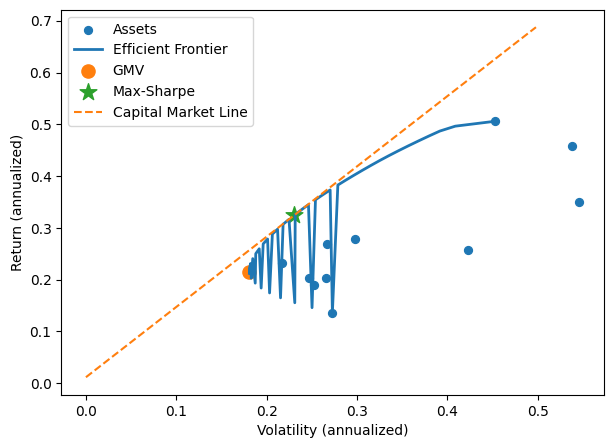

In [81]:
# ---------- helper: min-variance portfolio for a target return ----------
def solve_min_variance_for_target_return(
    asset_expected_returns_annual: np.ndarray,
    asset_return_covariance_annual: np.ndarray,
    target_return_annual: float,
    weight_bounds_per_asset=(0.0, 1.0),
):
    n_assets = asset_expected_returns_annual.size
    initial_equal_weight_guess = np.full(n_assets, 1.0 / n_assets)

    constraints = (
        {"type": "eq", "fun": lambda w: w.sum() - 1.0},  # fully invested
        {"type": "eq", "fun": lambda w: float(w @ asset_expected_returns_annual) - float(target_return_annual)},
    )
    per_asset_bounds = (weight_bounds_per_asset,) * n_assets
    variance_objective = lambda w: float(w @ asset_return_covariance_annual @ w)

    res = minimize(variance_objective, initial_equal_weight_guess,
                   method="SLSQP", bounds=per_asset_bounds, constraints=constraints)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x

# ---------- build frontier points ----------
# Uses variables you already prepared earlier:
# asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual
# maximum_sharpe_weights, global_min_var_weights, compute_portfolio_statistics

target_returns_annual = np.linspace(
    asset_expected_returns_annual.min(), asset_expected_returns_annual.max(), 40
)

frontier_points = []
for target_mu in target_returns_annual:
    try:
        w_star = solve_min_variance_for_target_return(
            asset_expected_returns_annual,
            asset_return_covariance_annual,
            target_mu,
            weight_bounds_per_asset=(0.0, 1.0),
        )
        ret, vol, _ = compute_portfolio_statistics(
            w_star,
            asset_expected_returns_annual,
            asset_return_covariance_annual,
            risk_free_rate_annual,
        )
        frontier_points.append((vol, ret))
    except RuntimeError:
        # infeasible targets under long-only constraints → skip
        pass

frontier_df = pd.DataFrame(frontier_points, columns=["vol_annual", "ret_annual"]).sort_values("vol_annual")

# ---------- points for assets, GMV, Max-Sharpe, and CML ----------
asset_vols_annual = np.sqrt(np.diag(asset_return_covariance_annual))
asset_rets_annual = asset_expected_returns_annual

gmv_ret, gmv_vol, gmv_sharpe = compute_portfolio_statistics(
    global_min_var_weights, asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual
)
msr_ret, msr_vol, msr_sharpe = compute_portfolio_statistics(
    maximum_sharpe_weights, asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual
)

# Capital Market Line (through risk-free point with slope = tangency Sharpe)
cml_vol_axis = np.linspace(0.0, max(frontier_df["vol_annual"].max(), msr_vol) * 1.1, 60)
cml_ret_axis = risk_free_rate_annual + msr_sharpe * cml_vol_axis

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(asset_vols_annual, asset_rets_annual, s=32, label="Assets")
ax.plot(frontier_df["vol_annual"], frontier_df["ret_annual"], lw=2, label="Efficient Frontier")
ax.scatter([gmv_vol], [gmv_ret], marker="o", s=90, label="GMV")
ax.scatter([msr_vol], [msr_ret], marker="*", s=160, label="Max-Sharpe")
ax.plot(cml_vol_axis, cml_ret_axis, linestyle="--", label="Capital Market Line")

ax.set_xlabel("Volatility (annualized)")
ax.set_ylabel("Return (annualized)")
ax.legend()
plt.show()


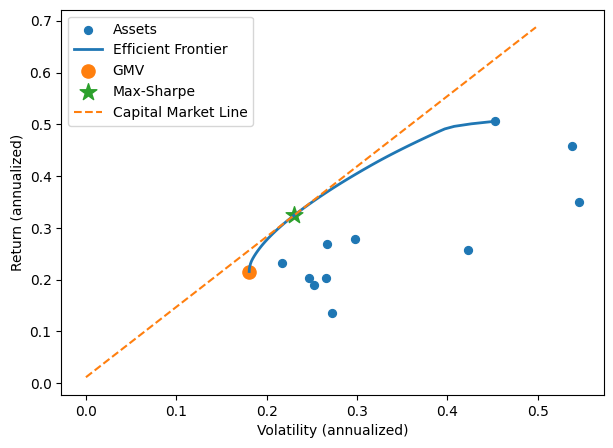

In [82]:
# Clean, smooth efficient frontier (inequality + warm start)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def solve_min_variance_at_least_target(mu, Sigma, target, w0=None, bounds=(0.0,1.0)):
    n = mu.size
    if w0 is None:
        w0 = np.full(n, 1.0/n)

    constraints = (
        {"type": "eq",   "fun": lambda w: w.sum() - 1.0},         # fully invested
        {"type": "ineq", "fun": lambda w: float(w @ mu) - target} # w·mu >= target
    )
    bnds = (bounds,) * n
    obj  = lambda w: float(w @ Sigma @ w)

    res = minimize(obj, w0, method="SLSQP", bounds=bnds, constraints=constraints,
                   options={"ftol": 1e-12, "maxiter": 1000})
    if not res.success:
        raise RuntimeError(res.message)
    return res.x

# Inputs you already have:
# asset_expected_returns_annual (mu), asset_return_covariance_annual (Sigma),
# global_min_var_weights, maximum_sharpe_weights, risk_free_rate_annual,
# compute_portfolio_statistics(...)

mu  = asset_expected_returns_annual
Sigma = asset_return_covariance_annual
rf = risk_free_rate_annual

# Start targets from the GMV return (feasible) up to the best asset's mu
gmv_ret, gmv_vol, _ = compute_portfolio_statistics(global_min_var_weights, mu, Sigma, rf)
mu_min = gmv_ret
mu_max = float(mu.max())
targets = np.linspace(mu_min, mu_max, 60)

frontier = []
w_prev = global_min_var_weights.copy()
for t in targets:
    try:
        w_star = solve_min_variance_at_least_target(mu, Sigma, t, w0=w_prev, bounds=(0.0,1.0))
        w_prev = w_star
        ret, vol, _ = compute_portfolio_statistics(w_star, mu, Sigma, rf)
        frontier.append((vol, ret))
    except RuntimeError:
        pass

frontier_df = pd.DataFrame(frontier, columns=["vol_annual","ret_annual"]).drop_duplicates().sort_values("vol_annual")

# Asset points
asset_vols = np.sqrt(np.diag(Sigma))
asset_rets = mu

# Max-Sharpe (tangency) stats & CML
msr_ret, msr_vol, msr_sharpe = compute_portfolio_statistics(maximum_sharpe_weights, mu, Sigma, rf)
cml_x = np.linspace(0.0, max(frontier_df["vol_annual"].max(), msr_vol)*1.1, 60)
cml_y = rf + msr_sharpe * cml_x

# Plot
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(asset_vols, asset_rets, s=32, label="Assets")
ax.plot(frontier_df["vol_annual"], frontier_df["ret_annual"], lw=2, label="Efficient Frontier")
ax.scatter([gmv_vol],[gmv_ret], s=90, marker="o", label="GMV")
ax.scatter([msr_vol],[msr_ret], s=160, marker="*", label="Max-Sharpe")
ax.plot(cml_x, cml_y, "--", label="Capital Market Line")
ax.set_xlabel("Volatility (annualized)")
ax.set_ylabel("Return (annualized)")
ax.legend()
plt.show()


/tmp/ipykernel_2280/3555012102.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_rate_annual_constant = float((rfr_monthly.mean() * 12))  # fallback for optimizer
/tmp/ipykernel_2280/3555012102.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_excess_net_return = realized_portfolio_net_return - float(risk_free_returns_monthly.loc[next_period_date])
/tmp/ipykernel_2280/3555012102.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_excess_net_return = realized_portfolio_net_return - float(risk_free_returns_monthly.loc[next_period_date])
/tmp/ipykernel_2280/3555012102.py:72: FutureWarning: Calling float on a single element Series is deprecated and will raise a Ty

,metric,value
0,CAGR (net),0.365610
1,Vol (ann),0.274888
2,"Sharpe (net, rf monthly)",1.228369
3,Max Drawdown,-0.410013
4,Avg Turnover (per rebalance),0.253244


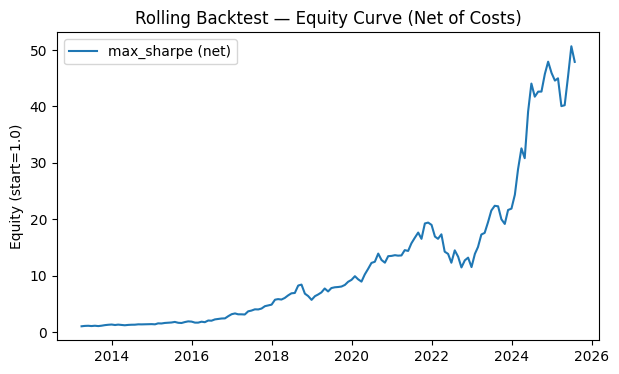

,gross_ret,net_ret,excess_net_ret,turnover,equity_gross,equity_net
date,,,,,,
2024-10-31,0.073667,0.073242,0.069294,0.424707,47.338692,45.755067
2024-11-30,0.047804,0.047651,0.043943,0.153467,49.601672,47.935321
2024-12-31,-0.041173,-0.041595,-0.045626,0.422060,47.559440,45.941466
2025-01-31,-0.029452,-0.029654,-0.033154,0.202448,46.158721,44.579099
2025-02-28,0.009476,0.009106,0.005868,0.369940,46.596122,44.985039
2025-03-31,-0.109524,-0.109641,-0.112911,0.116798,41.492727,40.052843
2025-04-30,0.004202,0.004018,0.000616,0.183743,41.667087,40.213793
2025-05-31,0.128401,0.127921,0.124289,0.479928,47.017192,45.357993
2025-06-30,0.117809,0.117077,0.113730,0.731821,52.556229,50.668368


In [83]:

# ---- Inputs you already have ----
# returns_m: monthly simple returns DataFrame for your assets (index: month-end, cols: tickers)
# rf_m     : monthly risk-free returns Series from BIL (optional; else zeros)
# compute_portfolio_statistics, solve_global_minimum_variance, solve_maximum_sharpe_ratio

# If you named them differently, map them here:
asset_returns_monthly = returns_monthly.copy()  # <-- ensure this exists from earlier steps
try:
    risk_free_returns_monthly = rfr_monthly.reindex(asset_returns_monthly.index).fillna(0.0)
    risk_free_rate_annual_constant = float((rfr_monthly.mean() * 12))  # fallback for optimizer
except NameError:
    risk_free_returns_monthly = pd.Series(0.0, index=asset_returns_monthly.index)
    risk_free_rate_annual_constant = 0.0

# ---- Backtest parameters (edit) ----
lookback_window_months = 36          # trailing window to estimate mu/Sigma
rebalance_every_n_months = 1         # monthly
use_strategy = "max_sharpe"          # "max_sharpe" or "gmv"
transaction_cost_bps_per_dollar = 10 # 10 bps per $ traded
transaction_cost_rate = transaction_cost_bps_per_dollar / 10_000.0

# ---- Helpers ----
def compute_max_drawdown(equity_curve: pd.Series) -> float:
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1.0
    return float(drawdown.min())

# ---- Rolling loop ----
dates = asset_returns_monthly.index
tickers = asset_returns_monthly.columns.tolist()

results = []
previous_portfolio_weights = None

for t in range(lookback_window_months, len(dates) - 1, rebalance_every_n_months):
    estimation_slice = slice(dates[t - lookback_window_months], dates[t])  # inclusive window
    next_period_date = dates[t + 1]

    window_returns = asset_returns_monthly.loc[estimation_slice, tickers]

    # Estimate annualized mu and Sigma from monthly data
    asset_expected_returns_annual = window_returns.mean().values * 12
    asset_return_covariance_annual = window_returns.cov().values * 12

    # Solve for target weights
    if use_strategy == "gmv":
        target_weights = solve_global_minimum_variance(
            asset_expected_returns_annual,
            asset_return_covariance_annual,
            weight_bounds_per_asset=(0.0, 1.0),
        )
    else:
        target_weights = solve_maximum_sharpe_ratio(
            asset_expected_returns_annual,
            asset_return_covariance_annual,
            risk_free_rate_annual=risk_free_rate_annual_constant,
            weight_bounds_per_asset=(0.0, 1.0),
        )

    # Realized next-month gross return
    next_month_asset_returns = asset_returns_monthly.loc[next_period_date, tickers].values
    realized_portfolio_gross_return = float(target_weights @ next_month_asset_returns)

    # Turnover & costs (approx: difference vs last target weights)
    if previous_portfolio_weights is None:
        turnover = float(np.abs(target_weights).sum())  # first trade from cash
    else:
        turnover = float(np.abs(target_weights - previous_portfolio_weights).sum())
    trading_cost = transaction_cost_rate * turnover

    realized_portfolio_net_return = realized_portfolio_gross_return - trading_cost
    realized_excess_net_return = realized_portfolio_net_return - float(risk_free_returns_monthly.loc[next_period_date])

    results.append({
        "date": next_period_date,
        "gross_ret": realized_portfolio_gross_return,
        "net_ret": realized_portfolio_net_return,
        "excess_net_ret": realized_excess_net_return,
        "turnover": turnover,
    })

    previous_portfolio_weights = target_weights

# ---- Results DataFrame ----
bt = pd.DataFrame(results).set_index("date").sort_index()

# Equity curves
bt["equity_gross"] = (1.0 + bt["gross_ret"]).cumprod()
bt["equity_net"]   = (1.0 + bt["net_ret"]).cumprod()

# Stats (annualized)
months = bt.shape[0]
cagr_net = bt["equity_net"].iloc[-1] ** (12 / months) - 1 if months > 0 else np.nan
vol_net  = bt["net_ret"].std() * np.sqrt(12)
sharpe_net = (bt["excess_net_ret"].mean() * 12) / (bt["net_ret"].std() * np.sqrt(12)) if bt["net_ret"].std() > 0 else np.nan
max_dd = compute_max_drawdown(bt["equity_net"])
avg_turnover = bt["turnover"].mean()

backtest_summary = pd.DataFrame({
    "metric": ["CAGR (net)", "Vol (ann)", "Sharpe (net, rf monthly)", "Max Drawdown", "Avg Turnover (per rebalance)"],
    "value":  [cagr_net,     vol_net,     sharpe_net,                 max_dd,         avg_turnover]
})
display(backtest_summary)

# ---- Plot equity (net of costs) ----
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(bt.index, bt["equity_net"], label=f"{use_strategy} (net)")
ax.set_title("Rolling Backtest — Equity Curve (Net of Costs)")
ax.set_ylabel("Equity (start=1.0)")
ax.legend()
plt.show()

bt.tail(10)


In [84]:
# ===== (A) Shrinkage covariance estimators =====
def estimate_covariance_shrinkage_annual(returns_window_monthly: pd.DataFrame, method: str = "ledoit_wolf"):
    """
    Returns an ANNUALIZED covariance matrix estimated on a monthly-returns window.
    method: "ledoit_wolf" (preferred) or "diagonal_shrink"
    """
    method = method.lower()
    if method == "ledoit_wolf":
        try:
            from sklearn.covariance import LedoitWolf
            lw = LedoitWolf().fit(returns_window_monthly.values)
            cov_monthly = lw.covariance_
        except Exception as e:
            # Fallback if scikit-learn isn't installed or any error occurs
            # Simple diagonal shrinkage toward the diagonal (alpha controls shrink intensity)
            cov_sample = returns_window_monthly.cov().values
            alpha = 0.5  # 0=no shrink, 1=all diagonal
            cov_diag = np.diag(np.diag(cov_sample))
            cov_monthly = alpha * cov_diag + (1 - alpha) * cov_sample
    else:
        cov_sample = returns_window_monthly.cov().values
        alpha = 0.5
        cov_diag = np.diag(np.diag(cov_sample))
        cov_monthly = alpha * cov_diag + (1 - alpha) * cov_sample

    return cov_monthly * 12.0  # annualize


# ===== (B) Portfolio stats (you already have this, kept here for completeness) =====
def compute_portfolio_statistics(
    portfolio_weights,
    asset_expected_returns_annual,
    asset_return_covariance_annual,
    risk_free_rate_annual=0.0,
):
    portfolio_weights = np.asarray(portfolio_weights, dtype=float)
    portfolio_expected_return_annual = float(portfolio_weights @ asset_expected_returns_annual)
    portfolio_volatility_annual = float(np.sqrt(portfolio_weights @ asset_return_covariance_annual @ portfolio_weights))
    portfolio_sharpe_ratio_annual = (
        (portfolio_expected_return_annual - risk_free_rate_annual) / portfolio_volatility_annual
        if portfolio_volatility_annual > 0
        else np.nan
    )
    return portfolio_expected_return_annual, portfolio_volatility_annual, portfolio_sharpe_ratio_annual


# ===== (C) CAPPED optimizers (long-only, fully invested, per-asset cap) =====
def solve_global_minimum_variance_capped(
    asset_expected_returns_annual,
    asset_return_covariance_annual,
    per_asset_weight_cap=0.30,  # e.g., 30% cap
):
    n_assets = len(asset_expected_returns_annual)
    initial_equal_weight_guess = np.full(n_assets, 1.0 / n_assets)
    constraints = ({"type": "eq", "fun": lambda w: w.sum() - 1.0},)
    bounds = tuple((0.0, per_asset_weight_cap) for _ in range(n_assets))

    def variance_objective(w):
        return float(w @ asset_return_covariance_annual @ w)

    res = minimize(variance_objective, initial_equal_weight_guess,
                   method="SLSQP", bounds=bounds, constraints=constraints)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x


def solve_maximum_sharpe_ratio_capped(
    asset_expected_returns_annual,
    asset_return_covariance_annual,
    risk_free_rate_annual=0.0,
    per_asset_weight_cap=0.30,
):
    n_assets = len(asset_expected_returns_annual)
    initial_equal_weight_guess = np.full(n_assets, 1.0 / n_assets)
    constraints = ({"type": "eq", "fun": lambda w: w.sum() - 1.0},)
    bounds = tuple((0.0, per_asset_weight_cap) for _ in range(n_assets))

    def negative_sharpe(w):
        _, _, sr = compute_portfolio_statistics(
            w, asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual
        )
        return -sr

    res = minimize(negative_sharpe, initial_equal_weight_guess,
                   method="SLSQP", bounds=bounds, constraints=constraints)
    if not res.success:
        raise RuntimeError(res.message)
    return res.x


# ===== (D) Utilities =====
def compute_max_drawdown(equity_curve: pd.Series) -> float:
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1.0
    return float(drawdown.min())


# ===== (E) Rolling backtest engine with options =====
def run_rolling_backtest(
    asset_returns_monthly: pd.DataFrame,
    risk_free_returns_monthly: pd.Series | float = 0.0,
    lookback_window_months: int = 36,
    rebalance_every_n_months: int = 1,
    strategy_name: str = "max_sharpe",  # "max_sharpe" or "gmv"
    use_covariance_shrinkage: bool = True,
    shrinkage_method: str = "ledoit_wolf",
    per_asset_weight_cap: float = 0.30,
    transaction_cost_bps_per_dollar: float = 10.0,
):
    """
    Returns (results_dataframe, summary_dataframe)
    """
    # Risk-free handling
    if isinstance(risk_free_returns_monthly, (int, float)):
        rf_m = pd.Series(float(risk_free_returns_monthly), index=asset_returns_monthly.index)
    else:
        rf_m = risk_free_returns_monthly.reindex(asset_returns_monthly.index).fillna(0.0)

    # Const rf for optimizer (annualized)
    risk_free_rate_annual_constant = float(rf_m.mean() * 12.0)

    dates = asset_returns_monthly.index
    tickers = asset_returns_monthly.columns.tolist()
    transaction_cost_rate = transaction_cost_bps_per_dollar / 10_000.0

    results_rows = []
    previous_weights = None

    for t in range(lookback_window_months, len(dates) - 1, rebalance_every_n_months):
        estimation_slice = slice(dates[t - lookback_window_months], dates[t])
        next_period_date = dates[t + 1]

        window_returns = asset_returns_monthly.loc[estimation_slice, tickers]

        # μ and Σ estimators (annualized)
        asset_expected_returns_annual = window_returns.mean().values * 12.0
        if use_covariance_shrinkage:
            asset_return_covariance_annual = estimate_covariance_shrinkage_annual(
                window_returns, method=shrinkage_method
            )
        else:
            asset_return_covariance_annual = window_returns.cov().values * 12.0

        # Optimizer selection with cap
        if strategy_name.lower() == "gmv":
            target_weights = solve_global_minimum_variance_capped(
                asset_expected_returns_annual, asset_return_covariance_annual,
                per_asset_weight_cap=per_asset_weight_cap,
            )
        else:
            target_weights = solve_maximum_sharpe_ratio_capped(
                asset_expected_returns_annual, asset_return_covariance_annual,
                risk_free_rate_annual=risk_free_rate_annual_constant,
                per_asset_weight_cap=per_asset_weight_cap,
            )

        # Realized next-month return
        next_month_asset_returns = asset_returns_monthly.loc[next_period_date, tickers].values
        realized_gross_return = float(target_weights @ next_month_asset_returns)

        # Turnover & transaction costs
        if previous_weights is None:
            turnover = float(np.abs(target_weights).sum())  # from cash on first trade
        else:
            turnover = float(np.abs(target_weights - previous_weights).sum())
        trading_cost = transaction_cost_rate * turnover
        realized_net_return = realized_gross_return - trading_cost

        realized_excess_net_return = realized_net_return - float(rf_m.loc[next_period_date])

        results_rows.append({
            "date": next_period_date,
            "gross_ret": realized_gross_return,
            "net_ret": realized_net_return,
            "excess_net_ret": realized_excess_net_return,
            "turnover": turnover,
        })

        previous_weights = target_weights

    bt = pd.DataFrame(results_rows).set_index("date").sort_index()

    # Equity curves
    bt["equity_gross"] = (1.0 + bt["gross_ret"]).cumprod()
    bt["equity_net"]   = (1.0 + bt["net_ret"]).cumprod()

    # Summary stats (annualized)
    months = bt.shape[0]
    cagr_net = bt["equity_net"].iloc[-1] ** (12.0 / months) - 1.0 if months > 0 else np.nan
    vol_net  = bt["net_ret"].std() * np.sqrt(12.0)
    sharpe_net = (
        (bt["excess_net_ret"].mean() * 12.0) / (bt["net_ret"].std() * np.sqrt(12.0))
        if bt["net_ret"].std() > 0 else np.nan
    )
    max_dd = compute_max_drawdown(bt["equity_net"])
    avg_turnover = bt["turnover"].mean()

    summary = pd.DataFrame({
        "metric": [
            "CAGR (net)", "Vol (ann)", "Sharpe (net, rf monthly)",
            "Max Drawdown", "Avg Turnover (per rebalance)"
        ],
        "value": [cagr_net, vol_net, sharpe_net, max_dd, avg_turnover],
    })

    return bt, summary


/tmp/ipykernel_2280/3430691762.py:121: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_rate_annual_constant = float(rf_m.mean() * 12.0)
/tmp/ipykernel_2280/3430691762.py:170: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_excess_net_return = realized_net_return - float(rf_m.loc[next_period_date])
/tmp/ipykernel_2280/3430691762.py:170: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_excess_net_return = realized_net_return - float(rf_m.loc[next_period_date])


/tmp/ipykernel_2280/3430691762.py:170: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_excess_net_return = realized_net_return - float(rf_m.loc[next_period_date])
/tmp/ipykernel_2280/3430691762.py:170: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_excess_net_return = realized_net_return - float(rf_m.loc[next_period_date])
/tmp/ipykernel_2280/3430691762.py:170: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_excess_net_return = realized_net_return - float(rf_m.loc[next_period_date])
/tmp/ipykernel_2280/3430691762.py:170: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  realized_

,GMV (cap/shrink),MaxSharpe (cap/shrink)
metric,,
CAGR (net),0.230377,0.318012
Vol (ann),0.181036,0.240743
"Sharpe (net, rf monthly)",1.163916,1.217831
Max Drawdown,-0.397785,-0.410619
Avg Turnover (per rebalance),0.097435,0.194817


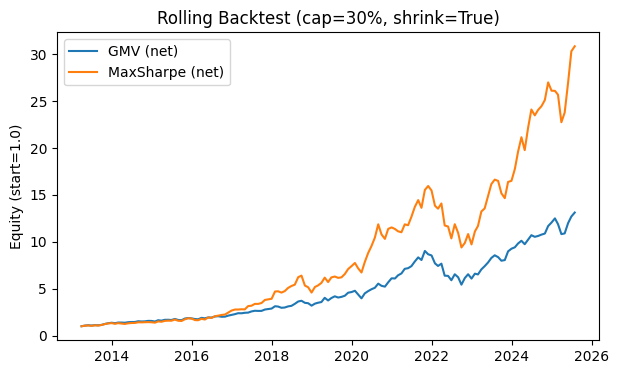

,gross_ret,net_ret,excess_net_ret,turnover,equity_gross,equity_net
date,,,,,,
2024-10-31,0.027345,0.027037,0.023089,0.308076,25.785904,25.106821
2024-11-30,0.074816,0.074752,0.071044,0.063995,27.715091,26.983595
2024-12-31,-0.032635,-0.032773,-0.036805,0.137953,26.810597,26.099252
2025-01-31,-0.000541,-0.000617,-0.004117,0.075789,26.796089,26.083150
2025-02-28,-0.015331,-0.015701,-0.018938,0.369198,26.385269,25.673630
2025-03-31,-0.114033,-0.114302,-0.117572,0.268883,23.376471,22.739080
2025-04-30,0.045195,0.045056,0.041654,0.138319,24.432963,23.763620
2025-05-31,0.133656,0.133464,0.129832,0.192397,27.698586,26.935209
2025-06-30,0.125232,0.124921,0.121574,0.310647,31.167328,30.299985


In [85]:
import matplotlib.pyplot as plt

# ----- Map your earlier variables to these names if needed -----
asset_returns_monthly = returns_monthly.copy()  # your monthly asset returns DataFrame
try:
    risk_free_returns_monthly = rfr_monthly.reindex(asset_returns_monthly.index).fillna(0.0)
except NameError:
    risk_free_returns_monthly = pd.Series(0.0, index=asset_returns_monthly.index)

# ----- Backtest settings -----
lookback_window_months = 36
rebalance_every_n_months = 1
per_asset_weight_cap = 0.30               # try 0.20–0.35 to see concentration effects
use_covariance_shrinkage = True           # set False to compare against sample cov
shrinkage_method = "ledoit_wolf"          # or "diagonal_shrink"
transaction_cost_bps_per_dollar = 10.0

# ----- Run both strategies -----
bt_gmv, smry_gmv = run_rolling_backtest(
    asset_returns_monthly, risk_free_returns_monthly,
    lookback_window_months, rebalance_every_n_months,
    strategy_name="gmv",
    use_covariance_shrinkage=use_covariance_shrinkage,
    shrinkage_method=shrinkage_method,
    per_asset_weight_cap=per_asset_weight_cap,
    transaction_cost_bps_per_dollar=transaction_cost_bps_per_dollar,
)

bt_msr, smry_msr = run_rolling_backtest(
    asset_returns_monthly, risk_free_returns_monthly,
    lookback_window_months, rebalance_every_n_months,
    strategy_name="max_sharpe",
    use_covariance_shrinkage=use_covariance_shrinkage,
    shrinkage_method=shrinkage_method,
    per_asset_weight_cap=per_asset_weight_cap,
    transaction_cost_bps_per_dollar=transaction_cost_bps_per_dollar,
)

# ----- Combine summaries -----
summary_compare = pd.concat(
    [
        smry_gmv.set_index("metric").rename(columns={"value": "GMV (cap/shrink)"}),
        smry_msr.set_index("metric").rename(columns={"value": "MaxSharpe (cap/shrink)"}),
    ],
    axis=1
)
display(summary_compare)

# ----- Plot both equity curves (net of costs) -----
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(bt_gmv.index, bt_gmv["equity_net"], label="GMV (net)")
ax.plot(bt_msr.index, bt_msr["equity_net"], label="MaxSharpe (net)")
ax.set_title(f"Rolling Backtest (cap={per_asset_weight_cap:.0%}, shrink={use_covariance_shrinkage})")
ax.set_ylabel("Equity (start=1.0)")
ax.legend()
plt.show()

bt_msr.tail(10)


In [86]:
# =========================
# Helpers (self-contained)
# =========================
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf

# ---------- (A) Portfolio stats ----------
def compute_portfolio_statistics(
    portfolio_weights: np.ndarray,
    asset_expected_returns_annual: np.ndarray,
    asset_return_covariance_annual: np.ndarray,
    risk_free_rate_annual: float = 0.0,
):
    """
    Returns a tuple: (expected_return_annual, volatility_annual, sharpe_ratio_annual).
    All inputs must be ANNUALIZED and aligned to the same assets/order.
    """
    w = np.asarray(portfolio_weights, dtype=float)
    mu = np.asarray(asset_expected_returns_annual, dtype=float)
    Sigma = np.asarray(asset_return_covariance_annual, dtype=float)

    expected_return_annual = float(w @ mu)
    volatility_annual = float(np.sqrt(w @ Sigma @ w))
    sharpe_ratio_annual = (
        (expected_return_annual - risk_free_rate_annual) / volatility_annual
        if volatility_annual > 0 else np.nan
    )
    return expected_return_annual, volatility_annual, sharpe_ratio_annual


# ---------- (B) Covariance shrinkage ----------
def estimate_covariance_shrinkage_annual(
    returns_window_monthly: pd.DataFrame,
    method: str = "ledoit_wolf",
) -> np.ndarray:
    """
    Estimate an ANNUALIZED covariance matrix from a monthly-returns window.
    - method="ledoit_wolf" (preferred), falls back to simple diagonal shrink if sklearn unavailable.
    - method="diagonal_shrink": 50% toward diagonal target.
    """
    method = method.lower()
    if method == "ledoit_wolf":
        try:
            from sklearn.covariance import LedoitWolf
            lw = LedoitWolf().fit(returns_window_monthly.values)
            cov_monthly = lw.covariance_
        except Exception:
            cov_sample = returns_window_monthly.cov().values
            alpha = 0.5
            cov_diag = np.diag(np.diag(cov_sample))
            cov_monthly = alpha * cov_diag + (1 - alpha) * cov_sample
    else:
        cov_sample = returns_window_monthly.cov().values
        alpha = 0.5
        cov_diag = np.diag(np.diag(cov_sample))
        cov_monthly = alpha * cov_diag + (1 - alpha) * cov_sample

    return cov_monthly * 12.0  # annualize


def compute_asset_betas_vs_market_monthly(
    returns_window_monthly: pd.DataFrame,
    market_returns_window_monthly,  # Series OR DataFrame
) -> np.ndarray:
    """
    beta_i = Cov(asset_i, market) / Var(market) on the given window.
    Returns np.ndarray of shape (n_assets,), aligned with returns_window_monthly.columns.
    """

    # ---- Normalize market to a 1-col DataFrame named "MKT" ----
    if isinstance(market_returns_window_monthly, pd.Series):
        mkt_df = market_returns_window_monthly.to_frame(name="MKT")
    elif isinstance(market_returns_window_monthly, pd.DataFrame):
        df = market_returns_window_monthly.copy()
        if "MKT" in df.columns and df["MKT"].ndim == 1:
            mkt_df = df[["MKT"]]
        elif df.shape[1] == 1:
            mkt_df = df.copy()
            mkt_df.columns = ["MKT"]
        else:
            # If multiple columns were provided, use the first as the proxy
            mkt_df = df.iloc[:, [0]].copy()
            mkt_df.columns = ["MKT"]
    else:
        # Last-resort: try to coerce to Series, then to DataFrame
        s = pd.Series(market_returns_window_monthly)
        mkt_df = s.to_frame(name="MKT")

    # ---- Align on dates and drop NaNs ----
    aligned = returns_window_monthly.join(mkt_df, how="inner").dropna()

    n_assets = returns_window_monthly.shape[1]
    if aligned.shape[0] < 3:
        return np.ones(n_assets, dtype=float)

    mkt = aligned["MKT"]
    var_mkt = mkt.var()
    if var_mkt <= 0:
        return np.ones(n_assets, dtype=float)

    # ---- Compute betas in the original column order ----
    betas = []
    for col in returns_window_monthly.columns:
        if col in aligned.columns:
            cov_im = aligned[col].cov(mkt)
            betas.append(cov_im / var_mkt)
        else:
            betas.append(1.0)
    return np.asarray(betas, dtype=float)

# ---------- (D) Optimizers with caps and optional beta cap ----------
def solve_global_minimum_variance_capped_beta(
    asset_expected_returns_annual: np.ndarray,
    asset_return_covariance_annual: np.ndarray,
    per_asset_weight_cap: float = 0.30,
    asset_betas_vs_market: np.ndarray | None = None,
    portfolio_beta_cap: float | None = None,  # e.g., 1.0 → w·beta ≤ 1.0
) -> np.ndarray:
    n = asset_expected_returns_annual.size
    w0 = np.full(n, 1.0 / n)
    bounds = tuple((0.0, per_asset_weight_cap) for _ in range(n))

    constraints = [{"type": "eq", "fun": lambda w: w.sum() - 1.0}]
    if (asset_betas_vs_market is not None) and (portfolio_beta_cap is not None):
        constraints.append({"type": "ineq",
                            "fun": lambda w, b=asset_betas_vs_market, cap=portfolio_beta_cap: cap - float(w @ b)})

    objective = lambda w: float(w @ asset_return_covariance_annual @ w)

    res = minimize(objective, w0, method="SLSQP", bounds=bounds, constraints=tuple(constraints))
    if not res.success:
        raise RuntimeError(res.message)
    return res.x


def solve_maximum_sharpe_ratio_capped_beta(
    asset_expected_returns_annual: np.ndarray,
    asset_return_covariance_annual: np.ndarray,
    risk_free_rate_annual: float = 0.0,
    per_asset_weight_cap: float = 0.30,
    asset_betas_vs_market: np.ndarray | None = None,
    portfolio_beta_cap: float | None = None,
) -> np.ndarray:
    n = asset_expected_returns_annual.size
    w0 = np.full(n, 1.0 / n)
    bounds = tuple((0.0, per_asset_weight_cap) for _ in range(n))

    constraints = [{"type": "eq", "fun": lambda w: w.sum() - 1.0}]
    if (asset_betas_vs_market is not None) and (portfolio_beta_cap is not None):
        constraints.append({"type": "ineq",
                            "fun": lambda w, b=asset_betas_vs_market, cap=portfolio_beta_cap: cap - float(w @ b)})

    def negative_sharpe(w):
        _, _, sr = compute_portfolio_statistics(
            w, asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual
        )
        return -sr

    res = minimize(negative_sharpe, w0, method="SLSQP", bounds=bounds, constraints=tuple(constraints))
    if not res.success:
        raise RuntimeError(res.message)
    return res.x


# ---------- (E) Rolling backtest engine (caps, beta cap, shrinkage, costs) ----------
def run_rolling_backtest_with_beta_cap(
    asset_returns_monthly: pd.DataFrame,
    market_returns_monthly: pd.Series,
    risk_free_returns_monthly: pd.Series | float = 0.0,
    lookback_window_months: int = 36,
    rebalance_every_n_months: int = 1,
    strategy_name: str = "max_sharpe",      # "gmv" or "max_sharpe"
    use_covariance_shrinkage: bool = True,
    covariance_shrinkage_method: str = "ledoit_wolf",
    per_asset_weight_cap: float = 0.30,
    portfolio_beta_cap: float | None = 1.00,  # set None to disable beta constraint
    transaction_cost_bps_per_dollar: float = 10.0,
):
    # Risk-free handling
    if isinstance(risk_free_returns_monthly, (int, float)):
        rf_m = pd.Series(float(risk_free_returns_monthly), index=asset_returns_monthly.index)
    else:
        rf_m = risk_free_returns_monthly.reindex(asset_returns_monthly.index).fillna(0.0)

    rf_ann_for_optimizer = float(rf_m.mean() * 12.0)

    dates = asset_returns_monthly.index
    tickers = asset_returns_monthly.columns.tolist()
    cost_rate = transaction_cost_bps_per_dollar / 10_000.0

    rows = []
    prev_weights = None

    # rolling window
    for t in range(lookback_window_months, len(dates) - 1, rebalance_every_n_months):
        window_slice = slice(dates[t - lookback_window_months], dates[t])
        next_date = dates[t + 1]

        R_win = asset_returns_monthly.loc[window_slice, tickers]
        M_win = market_returns_monthly.loc[window_slice]

        mu_ann = R_win.mean().values * 12.0
        if use_covariance_shrinkage:
            Sigma_ann = estimate_covariance_shrinkage_annual(R_win, method=covariance_shrinkage_method)
        else:
            Sigma_ann = R_win.cov().values * 12.0

        betas = compute_asset_betas_vs_market_monthly(R_win, M_win)  # (n,)

        if strategy_name.lower() == "gmv":
            target_weights = solve_global_minimum_variance_capped_beta(
                mu_ann, Sigma_ann, per_asset_weight_cap=per_asset_weight_cap,
                asset_betas_vs_market=betas, portfolio_beta_cap=portfolio_beta_cap
            )
        else:
            target_weights = solve_maximum_sharpe_ratio_capped_beta(
                mu_ann, Sigma_ann, risk_free_rate_annual=rf_ann_for_optimizer,
                per_asset_weight_cap=per_asset_weight_cap,
                asset_betas_vs_market=betas, portfolio_beta_cap=portfolio_beta_cap
            )

        # realized next month
        r_next = asset_returns_monthly.loc[next_date, tickers].values
        gross_ret = float(target_weights @ r_next)

        # turnover and costs
        if prev_weights is None:
            turnover = float(np.abs(target_weights).sum())  # from cash
        else:
            turnover = float(np.abs(target_weights - prev_weights).sum())
        trading_cost = cost_rate * turnover

        net_ret = gross_ret - trading_cost
        excess_net_ret = net_ret - float(rf_m.loc[next_date])

        rows.append({"date": next_date, "gross_ret": gross_ret, "net_ret": net_ret,
                     "excess_net_ret": excess_net_ret, "turnover": turnover})

        prev_weights = target_weights

    bt = pd.DataFrame(rows).set_index("date").sort_index()
    bt["equity_gross"] = (1.0 + bt["gross_ret"]).cumprod()
    bt["equity_net"]   = (1.0 + bt["net_ret"]).cumprod()

    # summary
    months = bt.shape[0]
    cagr_net = bt["equity_net"].iloc[-1] ** (12.0 / months) - 1.0 if months > 0 else np.nan
    vol_net  = bt["net_ret"].std() * np.sqrt(12.0)
    sharpe_net = ((bt["excess_net_ret"].mean() * 12.0) / (bt["net_ret"].std() * np.sqrt(12.0))
                  if bt["net_ret"].std() > 0 else np.nan)
    max_dd = float((bt["equity_net"] / bt["equity_net"].cummax() - 1.0).min())
    avg_turnover = bt["turnover"].mean()

    summary = pd.DataFrame({
        "metric": ["CAGR (net)", "Vol (ann)", "Sharpe (net, rf monthly)", "Max Drawdown", "Avg Turnover"],
        "value":  [cagr_net,     vol_net,     sharpe_net,                 max_dd,         avg_turnover],
    })
    return bt, summary


# ---------- (F) Build/align market monthly returns (SPY proxy) ----------
def build_market_returns_monthly_from_spy(asset_returns_monthly: pd.DataFrame) -> pd.Series:
    """
    Downloads SPY, computes monthly returns, and aligns to asset_returns_monthly index.
    """
    start_dt = asset_returns_monthly.index.min().strftime("%Y-%m-%d")
    spy_px = yf.download("SPY", start=start_dt, end=None, auto_adjust=True, progress=False)["Close"]
    spy_ret_m = spy_px.resample("M").last().pct_change().dropna()
    return spy_ret_m.reindex(asset_returns_monthly.index).dropna()


In [92]:
print("types:", type(asset_returns_monthly), type(market_returns_monthly))
print("asset cols:", list(asset_returns_monthly.columns)[:5], "…")
if isinstance(market_returns_monthly, pd.DataFrame):
    print("market cols:", list(market_returns_monthly.columns))


types: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
asset cols: ['AAPL', 'AMD', 'AMZN', 'DIS', 'GOOGL'] …
market cols: ['SPY']


In [93]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- keep your existing compute_portfolio_statistics(...) and compute_asset_betas_vs_market_monthly(...) ---

def _condition_covariance(Sigma: np.ndarray) -> np.ndarray:
    """Symmetrize and add just enough jitter to make Sigma SPD."""
    Sigma = 0.5 * (Sigma + Sigma.T)
    evals = np.linalg.eigvalsh(Sigma)
    min_eig = float(evals.min())
    if min_eig <= 1e-10:
        jitter = (abs(min_eig) + 1e-8)
        Sigma = Sigma + np.eye(Sigma.shape[0]) * jitter
    return Sigma

def _effective_beta_cap(betas: np.ndarray, desired_cap: float | None, tol: float = 1e-6) -> float | None:
    """Ensure beta cap is feasible for long-only weights: min_beta ≤ w·beta ≤ max_beta."""
    if desired_cap is None:
        return None
    beta_min = float(np.min(betas))
    if desired_cap < beta_min - tol:
        return beta_min + tol  # smallest feasible cap
    return desired_cap

def _slsqp_options():
    return {"maxiter": 2000, "ftol": 1e-9, "disp": False}

def solve_global_minimum_variance_capped_beta(
    asset_expected_returns_annual: np.ndarray,
    asset_return_covariance_annual: np.ndarray,
    per_asset_weight_cap: float = 0.30,
    asset_betas_vs_market: np.ndarray | None = None,
    portfolio_beta_cap: float | None = None,
    initial_weights: np.ndarray | None = None,
) -> np.ndarray:
    n = asset_expected_returns_annual.size
    w0 = initial_weights if initial_weights is not None else np.full(n, 1.0 / n)
    bounds = tuple((0.0, per_asset_weight_cap) for _ in range(n))

    constraints = [{"type": "eq", "fun": lambda w: w.sum() - 1.0}]
    if (asset_betas_vs_market is not None) and (portfolio_beta_cap is not None):
        constraints.append({"type": "ineq",
                            "fun": lambda w, b=asset_betas_vs_market, cap=portfolio_beta_cap: cap - float(w @ b)})

    obj = lambda w: float(w @ asset_return_covariance_annual @ w)

    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=tuple(constraints), options=_slsqp_options())
    if not res.success and len(constraints) > 1:
        # Retry once without beta cap (graceful degradation)
        res2 = minimize(obj, w0, method="SLSQP", bounds=bounds,
                        constraints=({"type": "eq", "fun": lambda w: w.sum() - 1.0},),
                        options=_slsqp_options())
        if res2.success:
            return res2.x
    if not res.success:
        # Final fallback: previous weights or equal
        return w0
    return res.x

def solve_maximum_sharpe_ratio_capped_beta(
    asset_expected_returns_annual: np.ndarray,
    asset_return_covariance_annual: np.ndarray,
    risk_free_rate_annual: float = 0.0,
    per_asset_weight_cap: float = 0.30,
    asset_betas_vs_market: np.ndarray | None = None,
    portfolio_beta_cap: float | None = None,
    initial_weights: np.ndarray | None = None,
) -> np.ndarray:
    n = asset_expected_returns_annual.size
    w0 = initial_weights if initial_weights is not None else np.full(n, 1.0 / n)
    bounds = tuple((0.0, per_asset_weight_cap) for _ in range(n))

    constraints = [{"type": "eq", "fun": lambda w: w.sum() - 1.0}]
    if (asset_betas_vs_market is not None) and (portfolio_beta_cap is not None):
        constraints.append({"type": "ineq",
                            "fun": lambda w, b=asset_betas_vs_market, cap=portfolio_beta_cap: cap - float(w @ b)})

    def neg_sharpe(w):
        _, _, sr = compute_portfolio_statistics(w, asset_expected_returns_annual, asset_return_covariance_annual, risk_free_rate_annual)
        return -sr

    res = minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds, constraints=tuple(constraints), options=_slsqp_options())
    if not res.success and len(constraints) > 1:
        # Retry once without beta cap
        res2 = minimize(neg_sharpe, w0, method="SLSQP", bounds=bounds,
                        constraints=({"type": "eq", "fun": lambda w: w.sum() - 1.0},),
                        options=_slsqp_options())
        if res2.success:
            return res2.x
    if not res.success:
        return w0
    return res.x

def run_rolling_backtest_with_beta_cap(
    asset_returns_monthly: pd.DataFrame,
    market_returns_monthly: pd.Series,
    risk_free_returns_monthly: pd.Series | float = 0.0,
    lookback_window_months: int = 36,
    rebalance_every_n_months: int = 1,
    strategy_name: str = "max_sharpe",      # "gmv" or "max_sharpe"
    use_covariance_shrinkage: bool = True,
    covariance_shrinkage_method: str = "ledoit_wolf",
    per_asset_weight_cap: float = 0.30,
    portfolio_beta_cap: float | None = 1.00,  # set None to disable beta constraint
    transaction_cost_bps_per_dollar: float = 10.0,
):
    # Risk-free handling
    if isinstance(risk_free_returns_monthly, (int, float)):
        rf_m = pd.Series(float(risk_free_returns_monthly), index=asset_returns_monthly.index)
    else:
        rf_m = risk_free_returns_monthly.reindex(asset_returns_monthly.index).fillna(0.0)

    rf_ann_for_optimizer = float(rf_m.mean() * 12.0)
    dates = asset_returns_monthly.index
    tickers = asset_returns_monthly.columns.tolist()
    cost_rate = transaction_cost_bps_per_dollar / 10_000.0

    rows = []
    prev_w = None

    for t in range(lookback_window_months, len(dates) - 1, rebalance_every_n_months):
        window_slice = slice(dates[t - lookback_window_months], dates[t])
        next_date = dates[t + 1]

        R_win = asset_returns_monthly.loc[window_slice, tickers]
        M_win = market_returns_monthly.loc[window_slice]

        # μ and Σ (annualized)
        mu_ann = R_win.mean().values * 12.0
        if use_covariance_shrinkage:
            Sigma_ann = estimate_covariance_shrinkage_annual(R_win, method=covariance_shrinkage_method)
        else:
            Sigma_ann = R_win.cov().values * 12.0
        Sigma_ann = _condition_covariance(Sigma_ann)

        # betas & feasible beta cap
        betas = compute_asset_betas_vs_market_monthly(R_win, M_win)  # (n,)
        cap_eff = _effective_beta_cap(betas, portfolio_beta_cap)

        # solve with warm start
        if strategy_name.lower() == "gmv":
            w_tgt = solve_global_minimum_variance_capped_beta(
                mu_ann, Sigma_ann,
                per_asset_weight_cap=per_asset_weight_cap,
                asset_betas_vs_market=betas, portfolio_beta_cap=cap_eff,
                initial_weights=prev_w,
            )
        else:
            w_tgt = solve_maximum_sharpe_ratio_capped_beta(
                mu_ann, Sigma_ann, risk_free_rate_annual=rf_ann_for_optimizer,
                per_asset_weight_cap=per_asset_weight_cap,
                asset_betas_vs_market=betas, portfolio_beta_cap=cap_eff,
                initial_weights=prev_w,
            )

        # realized next-month return
        r_next = asset_returns_monthly.loc[next_date, tickers].values
        gross_ret = float(w_tgt @ r_next)

        # turnover & trading costs
        if prev_w is None:
            turnover = float(np.abs(w_tgt).sum())
        else:
            turnover = float(np.abs(w_tgt - prev_w).sum())
        net_ret = gross_ret - cost_rate * turnover
        excess_net_ret = net_ret - float(rf_m.loc[next_date])

        rows.append({"date": next_date, "gross_ret": gross_ret, "net_ret": net_ret,
                     "excess_net_ret": excess_net_ret, "turnover": turnover})
        prev_w = w_tgt

    bt = pd.DataFrame(rows).set_index("date").sort_index()
    bt["equity_gross"] = (1.0 + bt["gross_ret"]).cumprod()
    bt["equity_net"]   = (1.0 + bt["net_ret"]).cumprod()

    months = bt.shape[0]
    cagr_net = bt["equity_net"].iloc[-1] ** (12.0 / months) - 1.0 if months > 0 else np.nan
    vol_net  = bt["net_ret"].std() * np.sqrt(12.0)
    sharpe_net = ((bt["excess_net_ret"].mean() * 12.0) / (bt["net_ret"].std() * np.sqrt(12.0))
                  if bt["net_ret"].std() > 0 else np.nan)
    max_dd = float((bt["equity_net"] / bt["equity_net"].cummax() - 1.0).min())
    avg_turnover = bt["turnover"].mean()

    summary = pd.DataFrame({
        "metric": ["CAGR (net)", "Vol (ann)", "Sharpe (net, rf monthly)", "Max Drawdown", "Avg Turnover"],
        "value":  [cagr_net,     vol_net,     sharpe_net,                 max_dd,         avg_turnover],
    })
    return bt, summary


In [90]:
# Inspect beta feasibility on latest window
_last_R = asset_returns_monthly.iloc[-lookback_window_months:]
_last_M = market_returns_monthly.loc[_last_R.index]
_betas  = compute_asset_betas_vs_market_monthly(_last_R, _last_M)
print("min_beta =", _betas.min(), "max_beta =", _betas.max(), "cap =", portfolio_beta_cap)


min_beta = 0.9121232213946839 max_beta = 2.2836500481422486 cap = 1.0


/tmp/ipykernel_2280/2550063687.py:114: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rf_ann_for_optimizer = float(rf_m.mean() * 12.0)
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  excess_net_ret = net_ret - float(rf_m.loc[next_date])
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  excess_net_ret = net_ret - float(rf_m.loc[next_date])
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  excess_net_ret = net_ret - float(rf_m.loc[next_date])
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning:

,GMV (cap+beta),MaxSharpe (cap+beta)
metric,,
CAGR (net),0.235114,0.336872
Vol (ann),0.183974,0.229998
"Sharpe (net, rf monthly)",1.169541,1.326898
Max Drawdown,-0.397846,-0.381614
Avg Turnover,0.127489,0.243272


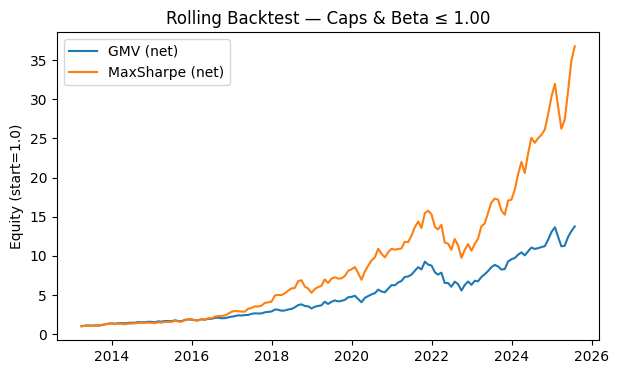

/tmp/ipykernel_2280/2550063687.py:114: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rf_ann_for_optimizer = float(rf_m.mean() * 12.0)
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  excess_net_ret = net_ret - float(rf_m.loc[next_date])
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  excess_net_ret = net_ret - float(rf_m.loc[next_date])
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  excess_net_ret = net_ret - float(rf_m.loc[next_date])
/tmp/ipykernel_2280/2550063687.py:167: FutureWarning:

,CAGR_net,Vol_ann,Sharpe_net,MaxDD
cost_bps,,,,
0,0.340658,0.230118,1.338890,-0.380304
5,0.338764,0.230057,1.332898,-0.380959
10,0.336872,0.229998,1.326898,-0.381614
25,0.331209,0.229823,1.308853,-0.383574
50,0.321816,0.229547,1.278630,-0.386828
100,0.303196,0.229055,1.217655,-0.393292


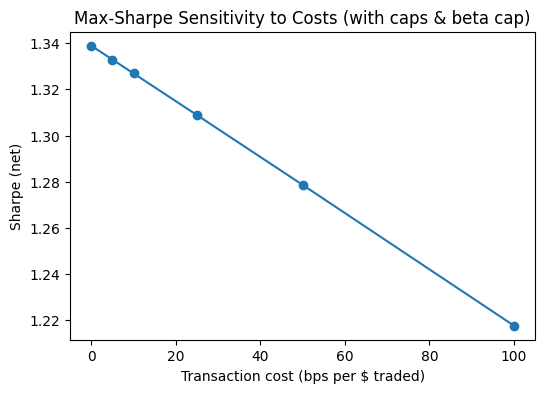

In [91]:
import matplotlib.pyplot as plt

# ---------- Map to canonical names (works with either set you already used) ----------
try:
    asset_returns_monthly = returns_monthly.copy()
except NameError:
    asset_returns_monthly = returns_monthly.copy()

try:
    risk_free_returns_monthly = rfr_monthly.reindex(asset_returns_monthly.index).fillna(0.0)
except NameError:
    try:
        risk_free_returns_monthly = rfr_monthly.reindex(asset_returns_monthly.index).fillna(0.0)
    except NameError:
        risk_free_returns_monthly = pd.Series(0.0, index=asset_returns_monthly.index)  # fallback: zero rf

# Build market proxy (SPY) if you don't already have one
try:
    market_returns_monthly
except NameError:
    market_returns_monthly = build_market_returns_monthly_from_spy(asset_returns_monthly)

# ---------- Settings you can tweak ----------
lookback_window_months = 36
per_asset_weight_cap = 0.30
portfolio_beta_cap = 1.00          # try 0.8 / 1.0 / 1.2
use_covariance_shrinkage = True
covariance_shrinkage_method = "ledoit_wolf"
transaction_cost_bps_per_dollar = 10.0

# ---------- Run GMV & Max-Sharpe with beta cap ----------
bt_gmv, smry_gmv = run_rolling_backtest_with_beta_cap(
    asset_returns_monthly=asset_returns_monthly,
    market_returns_monthly=market_returns_monthly,
    risk_free_returns_monthly=risk_free_returns_monthly,
    lookback_window_months=lookback_window_months,
    strategy_name="gmv",
    use_covariance_shrinkage=use_covariance_shrinkage,
    covariance_shrinkage_method=covariance_shrinkage_method,
    per_asset_weight_cap=per_asset_weight_cap,
    portfolio_beta_cap=portfolio_beta_cap,
    transaction_cost_bps_per_dollar=transaction_cost_bps_per_dollar,
)

bt_msr, smry_msr = run_rolling_backtest_with_beta_cap(
    asset_returns_monthly=asset_returns_monthly,
    market_returns_monthly=market_returns_monthly,
    risk_free_returns_monthly=risk_free_returns_monthly,
    lookback_window_months=lookback_window_months,
    strategy_name="max_sharpe",
    use_covariance_shrinkage=use_covariance_shrinkage,
    covariance_shrinkage_method=covariance_shrinkage_method,
    per_asset_weight_cap=per_asset_weight_cap,
    portfolio_beta_cap=portfolio_beta_cap,
    transaction_cost_bps_per_dollar=transaction_cost_bps_per_dollar,
)

# ---------- Compare summaries ----------
summary_compare = pd.concat(
    [
        smry_gmv.set_index("metric").rename(columns={"value": "GMV (cap+beta)"}),
        smry_msr.set_index("metric").rename(columns={"value": "MaxSharpe (cap+beta)"}),
    ],
    axis=1
)
display(summary_compare)

# ---------- Equity curves (net of costs) ----------
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(bt_gmv.index, bt_gmv["equity_net"], label="GMV (net)")
ax.plot(bt_msr.index, bt_msr["equity_net"], label="MaxSharpe (net)")
ax.set_title(f"Rolling Backtest — Caps & Beta ≤ {portfolio_beta_cap:.2f}")
ax.set_ylabel("Equity (start=1.0)")
ax.legend()
plt.show()

# ---------- Transaction-cost sensitivity sweep (bps per $ traded) ----------
cost_grid_bps = [0, 5, 10, 25, 50, 100]
rows = []
for bps in cost_grid_bps:
    bt_tmp, sm_tmp = run_rolling_backtest_with_beta_cap(
        asset_returns_monthly=asset_returns_monthly,
        market_returns_monthly=market_returns_monthly,
        risk_free_returns_monthly=risk_free_returns_monthly,
        lookback_window_months=lookback_window_months,
        strategy_name="max_sharpe",
        use_covariance_shrinkage=use_covariance_shrinkage,
        covariance_shrinkage_method=covariance_shrinkage_method,
        per_asset_weight_cap=per_asset_weight_cap,
        portfolio_beta_cap=portfolio_beta_cap,
        transaction_cost_bps_per_dollar=bps,
    )
    out = sm_tmp.set_index("metric")["value"]
    rows.append({
        "cost_bps": bps,
        "CAGR_net": out["CAGR (net)"],
        "Vol_ann": out["Vol (ann)"],
        "Sharpe_net": out["Sharpe (net, rf monthly)"],
        "MaxDD": out["Max Drawdown"],
    })

tc_sensitivity = pd.DataFrame(rows).set_index("cost_bps")
display(tc_sensitivity)

# Plot Sharpe vs costs
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tc_sensitivity.index, tc_sensitivity["Sharpe_net"], marker="o")
ax.set_xlabel("Transaction cost (bps per $ traded)")
ax.set_ylabel("Sharpe (net)")
ax.set_title("Max-Sharpe Sensitivity to Costs (with caps & beta cap)")
plt.show()


In [94]:
# === Export key artifacts ===
import os
import matplotlib.pyplot as plt

os.makedirs("artifacts", exist_ok=True)

# 1) Save comparison table & cost sweep
summary_compare.to_csv("artifacts/summary_compare.csv")
tc_sensitivity.to_csv("artifacts/transaction_cost_sensitivity.csv")

# 2) Save equity plot (GMV vs MaxSharpe)
fig, ax = plt.subplots(figsize=(8,4.5))
ax.plot(bt_gmv.index, bt_gmv["equity_net"], label="GMV (net)")
ax.plot(bt_msr.index, bt_msr["equity_net"], label="MaxSharpe (net)")
ax.set_title(f"Rolling Backtest — Caps & Beta ≤ {portfolio_beta_cap:.2f}")
ax.set_ylabel("Equity (start=1.0)")
ax.legend()
fig.tight_layout()
fig.savefig("artifacts/equity_curves.png", dpi=160)
plt.close(fig)

# 3) Save Sharpe vs cost plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(tc_sensitivity.index, tc_sensitivity["Sharpe_net"], marker="o")
ax.set_xlabel("Transaction cost (bps per $ traded)")
ax.set_ylabel("Sharpe (net)")
ax.set_title("Max-Sharpe Sensitivity to Costs")
fig.tight_layout()
fig.savefig("artifacts/sharpe_vs_cost.png", dpi=160)
plt.close(fig)

print("Saved:")
print("- artifacts/summary_compare.csv")
print("- artifacts/transaction_cost_sensitivity.csv")
print("- artifacts/equity_curves.png")
print("- artifacts/sharpe_vs_cost.png")


Saved:
- artifacts/summary_compare.csv
- artifacts/transaction_cost_sensitivity.csv
- artifacts/equity_curves.png
- artifacts/sharpe_vs_cost.png
